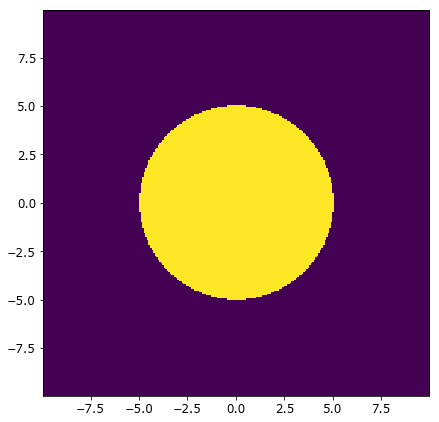

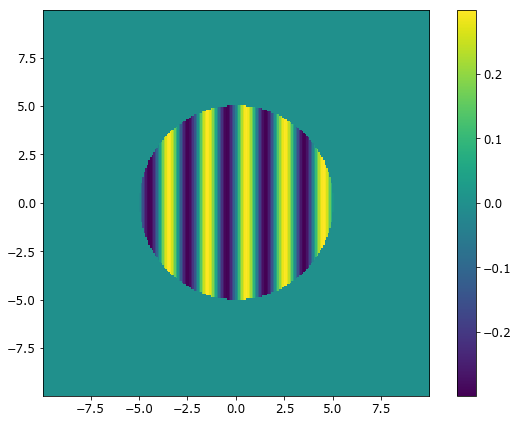

In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt
D_keck = 9.96
N = 256
keck_aperture = circular_aperture(D_keck)
pupil_grid = make_pupil_grid(N, D_keck * 2)

def aberrate(aperture, input_grid, f=1):
    wf = Wavefront(aperture(input_grid))
    return aberrate_wf(wf, f)

def aberrate_wf(wf, f=1):
    amplitude = 0.3
    spatial_frequency = 5
    wf.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D_keck * spatial_frequency))
    return wf

imshow_field(keck_aperture(pupil_grid))
plt.show()
aberrated = aberrate(keck_aperture, pupil_grid, 10)
imshow_field(aberrated.phase * keck_aperture(pupil_grid))
plt.colorbar()
plt.show()

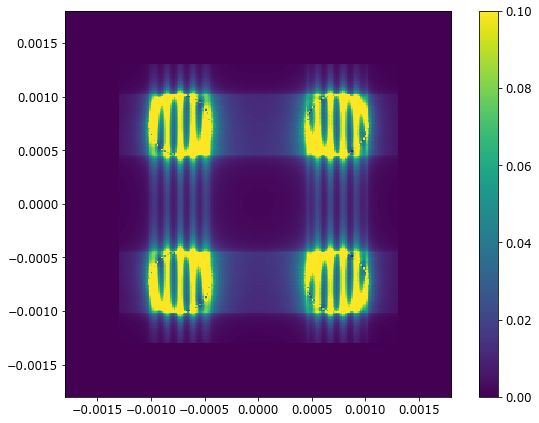

In [2]:
sps = 40 * 2 #sub-pupil size
pupsep = 1.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity
outgrid = np.zeros((N, N)).tolist()
pyramid_output.shape = (outgrid_size, outgrid_size)
buffer = (N - outgrid_size)//2
for rownum, row in enumerate(pyramid_output.tolist()):
    for colnum, el in enumerate(row):
        outgrid[rownum+buffer][colnum+buffer] = el

images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
imshow_field(images, vmax=0.1)
plt.colorbar()
plt.show()

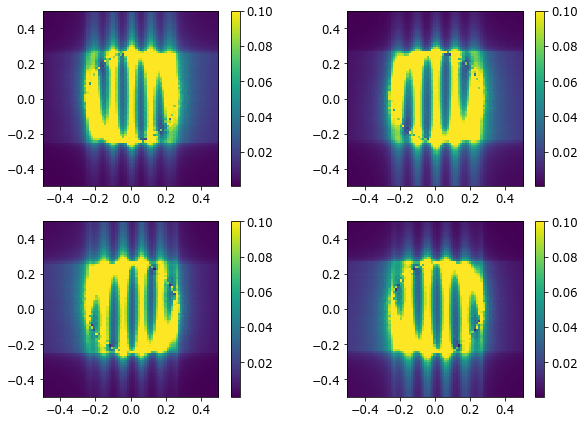

In [3]:
image = images.shaped
sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer], 
              image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
subimage_grid = make_pupil_grid(sps)
for count, img in enumerate(sub_images):
    img = img.ravel()
    img.grid = subimage_grid
    assert(img.is_valid_field)
    sub_images[count] = img
    plt.subplot(2,2,count+1)
    imshow_field(img, vmax=0.1)
    plt.colorbar()

plt.show()

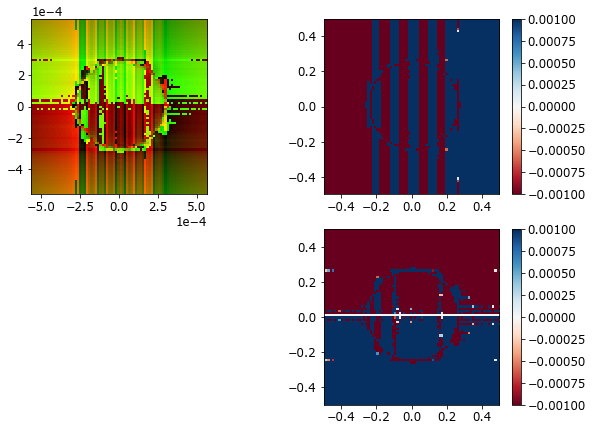

In [4]:
fake_pyramid_grid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, fake_pyramid_grid)

def estimate(EstimatorObject, images_list):
    I_b = images_list[0] 
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = (I_a - I_a)
    I_x = I_x.ravel()#[EstimatorObject.pupil_mask>0]
    I_y = I_y.ravel()#[EstimatorObject.pupil_mask>0]
    dummy = dummy.ravel()
    #EstimatorObject.pupil_mask is all 0s
    res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    return res, I_x, I_y
    
aberratedslopes, x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
plt.subplot(2,2,1)
imshow_field(aberratedslopes)
plt.subplot(2,2,2)
imshow_field(x_slopes, cmap='RdBu', vmin=-0.001, vmax=0.001)
plt.colorbar()
plt.subplot(2,2,4)
imshow_field(y_slopes, cmap='RdBu', vmin=-0.001, vmax=0.001)
plt.colorbar()
plt.show()

In [ ]:

#print(np.round(np.asarray(x_slopes) * 255/max(np.asarray(x_slopes).tolist())))
#x_slopes.shape = (sps, sps)
#y_slopes.shape = (sps, sps)
#x_resized = resize(x_slopes, (N, N))
#y_resized = resize(y_slopes, (N, N))
#x_slopes.ravel()
#y_slopes.ravel()

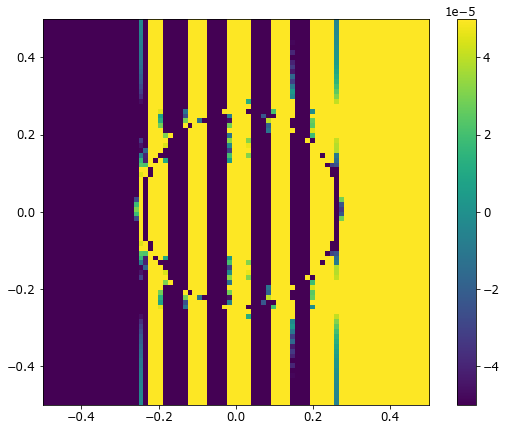

In [5]:
apex_max = 1e-3 #m
dzdx = apex_max * np.cos(np.pi * (1 - x_slopes.ravel())/ 2)
dzdy = apex_max * np.cos(np.pi * (1 - y_slopes.ravel())/ 2)
imshow_field(dzdx, vmax=0.00005, vmin=-0.00005)
plt.colorbar()
plt.show()